In [21]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
from lightgbm import LGBMRegressor


In [22]:

path_to_the_truth = r"../dados/microdados_enem_2019/dados_enem_processados_v2.csv.zip"

df = pd.read_csv(path_to_the_truth, sep=",", encoding="utf-8", compression="zip")




In [23]:
sample=df.sample(500000, random_state=666).copy()

In [24]:
sample.set_index('NU_INSCRICAO', inplace=True)

In [25]:
scaler = StandardScaler()
sample[['NOTA_ENEM_STD', 'SCORE_CULTURAL_STD']] = scaler.fit_transform(
    sample[['MEDIA_CANDIDATO', 'SCORE_CULT_PAIS']] 
)


In [26]:
categorical_cols = ['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'INTERNET']
df_encoded = pd.get_dummies(sample, columns=categorical_cols, drop_first=True)


In [27]:
Y = df_encoded['NOTA_ENEM_STD']     
T = df_encoded['SCORE_CULTURAL_STD'] 

# Confundidores (W) e variáveis de heterogeneidade (X)

X = df_encoded.drop(columns=['MEDIA_CANDIDATO', 'NOTA_ENEM_STD', 'SCORE_CULT_PAIS', 'SCORE_CULTURAL_STD'])
W = X.copy() # 


In [28]:
# vamo usar um modelo não tão grande para não overfittar
model_y = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
model_t = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)

est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    criterion='het',        #RESULTADOS EXPERIMENTAIS: 
    n_estimators=1000,       # Mais árvores = mais estabilidade no desvio 
    min_samples_leaf=500,    # Aumentar esse valor é o que mais reduz o desvio alto
    max_depth=5,             # Limita a complexidade da floresta
    discrete_treatment=False, #  tratamento agora é contínuo (vulgo Z-score)
    inference=True
)

#
est.fit(Y, T, X=X, W=W)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 38
[LightGBM] [Info] Start training from score -0.000624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

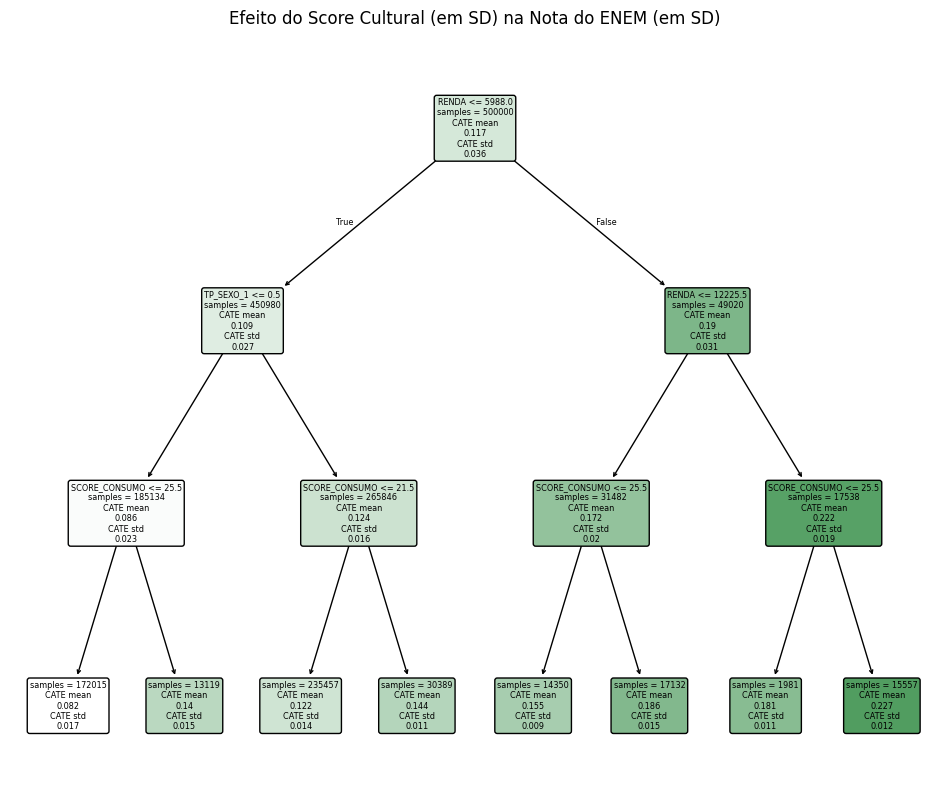

In [31]:

intrp = SingleTreeCateInterpreter(max_depth=3)
intrp.interpret(est, X)



plt.figure(figsize=(12, 10))
intrp.plot(feature_names=X.columns)
plt.title("Efeito do Score Cultural (em SD) na Nota do ENEM (em SD)")
plt.show()


In [30]:
ate = est.ate(X)
ate_interval = est.ate_interval(X)

scale = scaler.scale_[0]

ate_transformado = ate * scale

lower = ate_interval[0] * scale
upper = ate_interval[1] * scale

print(
    f"ATE estimado: {ate_transformado:.4f} "
)

print("-"*50)

print(
    f"Intervalo de confiança para o ATE: [{lower:.4f}, {upper:.4f}] "
)

ATE estimado: 9.4299 
--------------------------------------------------
Intervalo de confiança para o ATE: [7.9589, 10.9009] 
